## Imports

In [ ]:
%load_ext autoreload
%autoreload 2
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))

In [9]:
import pickle
import math
from functools import partial
import torch
import torch.nn as nn
from timm.models.vision_transformer import PatchEmbed, Block
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from model_scripts.mae_pos_embed import *
from model_scripts.train_model_mae import *
from model_scripts.MaskedAutoencoderViT import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from evaluation_scripts.patch_evaluation_helper import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import datetime
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Dataset prep: B10

Since we are implementing the 'Temporal-MAE', we work with RGB data. 

Initially, we work with 3 temporal images, exactly as done in the original MAE implementation.

In [10]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers, acquisition_dates, patch_tensor, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cube3('train', 'rgb')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cube3('eval', 'rgb')
patch_tensor.shape, patch_tensor_eval.shape

(torch.Size([1228, 3, 3, 64, 64]), torch.Size([48, 3, 3, 64, 64]))

Process the timestamps

In [11]:
timestamps = process_timestamps(field_numbers, acquisition_dates)
eval_timestamps = process_timestamps(field_numbers_eval, acquisition_dates_eval)
len(timestamps)

1228

Train-test split

In [12]:
train_tensor, test_tensor, train_field_numbers, test_field_numbers, timestamps_train, timestamps_test = train_test_split(
    patch_tensor, field_numbers, timestamps, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader_mae(train_tensor, train_field_numbers, timestamps_train, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader_mae(test_tensor, test_field_numbers, timestamps_test, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader_mae(patch_tensor_eval, field_numbers_eval, eval_timestamps, batch_size=config.ae_batch_size, shuffle=False)

Augmentation...

Not used as of now

In [13]:
# augmentations = get_augmentation_transforms()
# augmented_dataloader = create_augmented_data_loader(dataloader_train, augmentations)
# len(augmented_dataloader.dataset)

## Training the MAE

In [17]:
device = 'cuda'
epochs = 50
lr = 0.0001
momentum=0.9
latent_dim=32
channels = 3
time_steps = 3
optimizer = 'Adam'
patch_size = 16
masking_ratio = 0.75

In [18]:
model = MaskedAutoencoderViT(
        # img_size=64,
        patch_size=patch_size, embed_dim=768, depth=6, num_heads=6,
        decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=8,
        mlp_ratio=2, norm_layer=partial(nn.LayerNorm, eps=1e-6))
model.to(device)

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=1536, out_features=768, bias=True)
        (drop2):

In [19]:
trained_model, train_losses, test_losses = train_model_mae(model, dataloader_train, dataloader_test, epochs=epochs, masking_ratio=masking_ratio, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

Epoch 1/50, Train Loss: 0.138550, Test Loss: 0.077775
Epoch 2/50, Train Loss: 0.053468, Test Loss: 0.032891
Epoch 3/50, Train Loss: 0.023229, Test Loss: 0.015492
Epoch 4/50, Train Loss: 0.011880, Test Loss: 0.008900
Epoch 5/50, Train Loss: 0.007329, Test Loss: 0.005963
Epoch 6/50, Train Loss: 0.005143, Test Loss: 0.004393
Epoch 7/50, Train Loss: 0.003894, Test Loss: 0.003425
Epoch 8/50, Train Loss: 0.003097, Test Loss: 0.002782
Epoch 9/50, Train Loss: 0.002548, Test Loss: 0.002316
Epoch 10/50, Train Loss: 0.002151, Test Loss: 0.001977
Epoch 11/50, Train Loss: 0.001850, Test Loss: 0.001714
Epoch 12/50, Train Loss: 0.001623, Test Loss: 0.001509
Epoch 13/50, Train Loss: 0.001441, Test Loss: 0.001349
Epoch 14/50, Train Loss: 0.001296, Test Loss: 0.001215
Epoch 15/50, Train Loss: 0.001179, Test Loss: 0.001107
Epoch 16/50, Train Loss: 0.001079, Test Loss: 0.001019
Epoch 17/50, Train Loss: 0.000998, Test Loss: 0.000942
Epoch 18/50, Train Loss: 0.000927, Test Loss: 0.000878
Epoch 19/50, Train 

In [27]:
# plot_loss(train_losses, test_losses)

### Visualize Reconstructions

recon values tensor(0.0056, device='cuda:0') tensor(0.0252, device='cuda:0')


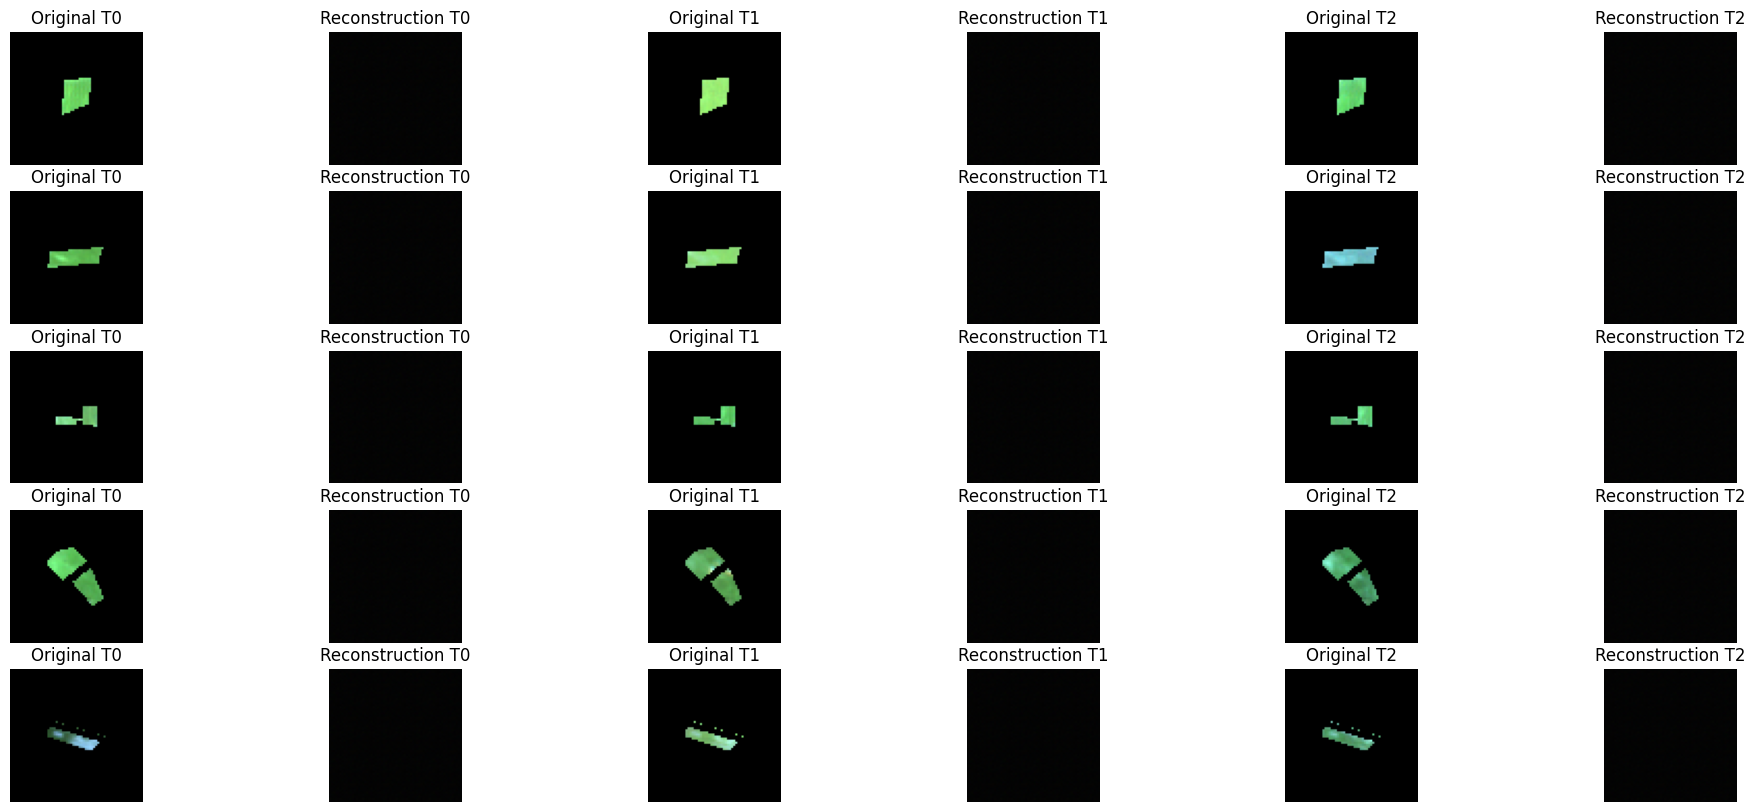

In [14]:
visualize_temporal_reconstructions_mae(trained_model, dataloader_eval, device, num_images=5, T=3)

Use trained Encoder part to get the features for train, test and evaluation Data

In [24]:
# train_features, train_fno = extract_latent_features_mae(trained_model, dataloader_train, device)
# test_features, test_fno = extract_latent_features_mae(trained_model, dataloader_test, device)
# eval_features, eval_fno = extract_latent_features_mae(trained_model, dataloader_eval, device)

# train_features = train_features.cpu()
# test_features = test_features.cpu()
# eval_features = eval_features.cpu()

# combined_train_features = torch.cat((train_features, test_features), dim=0)
# combined_train_coords = train_fno + test_fno

K-means on extracted features

In [25]:
# kmeans = kmeans_function(combined_train_features, n_clusters=2, random_state=201)

# train_patch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
# eval_patch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

In [26]:
# disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics_patch_level(field_numbers_eval, eval_patch_predictions, config.labels_path)
# print("Disease cluster:", disease)
# print("Accuracy:",acc)
# print("Precision:",precision)
# print("Recall:",recall)
# print("F1-score:",f1_score)
# print("F2-score:", f2_score)

## MAE with 7 Timesteps

In [12]:
preprocessing_pipeline = PreProcessingPipelineTemporal()
field_numbers, acquisition_dates, patch_tensor, images_visualisation_train = preprocessing_pipeline.get_processed_temporal_cubes('train', 'rgb')
field_numbers_eval, acquisition_dates_eval, patch_tensor_eval, images_visualisation_eval = preprocessing_pipeline.get_processed_temporal_cubes('eval', 'rgb')
patch_tensor.shape, patch_tensor_eval.shape

(torch.Size([2425, 7, 3, 64, 64]), torch.Size([48, 7, 3, 64, 64]))

In [13]:
timestamps = process_timestamps7(field_numbers, acquisition_dates)
eval_timestamps = process_timestamps7(field_numbers_eval, acquisition_dates_eval)
len(timestamps)

2425

In [14]:
train_tensor, test_tensor, train_field_numbers, test_field_numbers, timestamps_train, timestamps_test = train_test_split(
    patch_tensor, field_numbers, timestamps, test_size=1-config.ae_train_test_ratio, random_state=42
)

dataloader_train = create_data_loader_mae(train_tensor, train_field_numbers, timestamps_train, batch_size=config.ae_batch_size, shuffle=True)
dataloader_test = create_data_loader_mae(test_tensor, test_field_numbers, timestamps_test, batch_size=config.ae_batch_size, shuffle=False)
dataloader_eval = create_data_loader_mae(patch_tensor_eval, field_numbers_eval, eval_timestamps, batch_size=config.ae_batch_size, shuffle=False)

In [15]:
device = 'cuda'
epochs = 50
lr = 0.001
momentum=0.9
latent_dim=32
channels = 3
time_steps = 7
optimizer = 'Adam'
patch_size = 16
masking_ratio = 0.75

In [18]:
model = MaskedAutoencoderViT_7ts(
        # img_size=64,
        patch_size=patch_size, embed_dim=768, depth=6, num_heads=6,
        decoder_embed_dim=512, decoder_depth=2, decoder_num_heads=8,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6))
model.to(device)

MaskedAutoencoderViT_7ts(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (dro

In [19]:
trained_model, train_losses, test_losses = train_model_mae(model, dataloader_train, dataloader_test, epochs=epochs, masking_ratio=masking_ratio, optimizer=optimizer, lr=lr, momentum=momentum, device=device)

Epoch 1/50, Train Loss: 0.085933, Test Loss: 0.004241
Epoch 2/50, Train Loss: 0.001583, Test Loss: 0.000549
Epoch 3/50, Train Loss: 0.000441, Test Loss: 0.000361
Epoch 4/50, Train Loss: 0.000379, Test Loss: 0.000346
Epoch 5/50, Train Loss: 0.000366, Test Loss: 0.000339
Epoch 6/50, Train Loss: 0.000361, Test Loss: 0.000330
Epoch 7/50, Train Loss: 0.000356, Test Loss: 0.000335
Epoch 8/50, Train Loss: 0.000350, Test Loss: 0.000327
Epoch 9/50, Train Loss: 0.000347, Test Loss: 0.000323
Epoch 10/50, Train Loss: 0.000343, Test Loss: 0.000327
Epoch 11/50, Train Loss: 0.000347, Test Loss: 0.000321
Epoch 12/50, Train Loss: 0.000342, Test Loss: 0.000316
Epoch 13/50, Train Loss: 0.000345, Test Loss: 0.000325
Epoch 14/50, Train Loss: 0.000346, Test Loss: 0.000315
Epoch 15/50, Train Loss: 0.000339, Test Loss: 0.000313
Epoch 16/50, Train Loss: 0.000339, Test Loss: 0.000313
Epoch 17/50, Train Loss: 0.000336, Test Loss: 0.000313
Epoch 18/50, Train Loss: 0.000338, Test Loss: 0.000320
Epoch 19/50, Train 

In [33]:
# plot_loss(train_losses, test_losses)

### Visualisations

recon values tensor(-0.0418, device='cuda:0') tensor(0.0327, device='cuda:0')


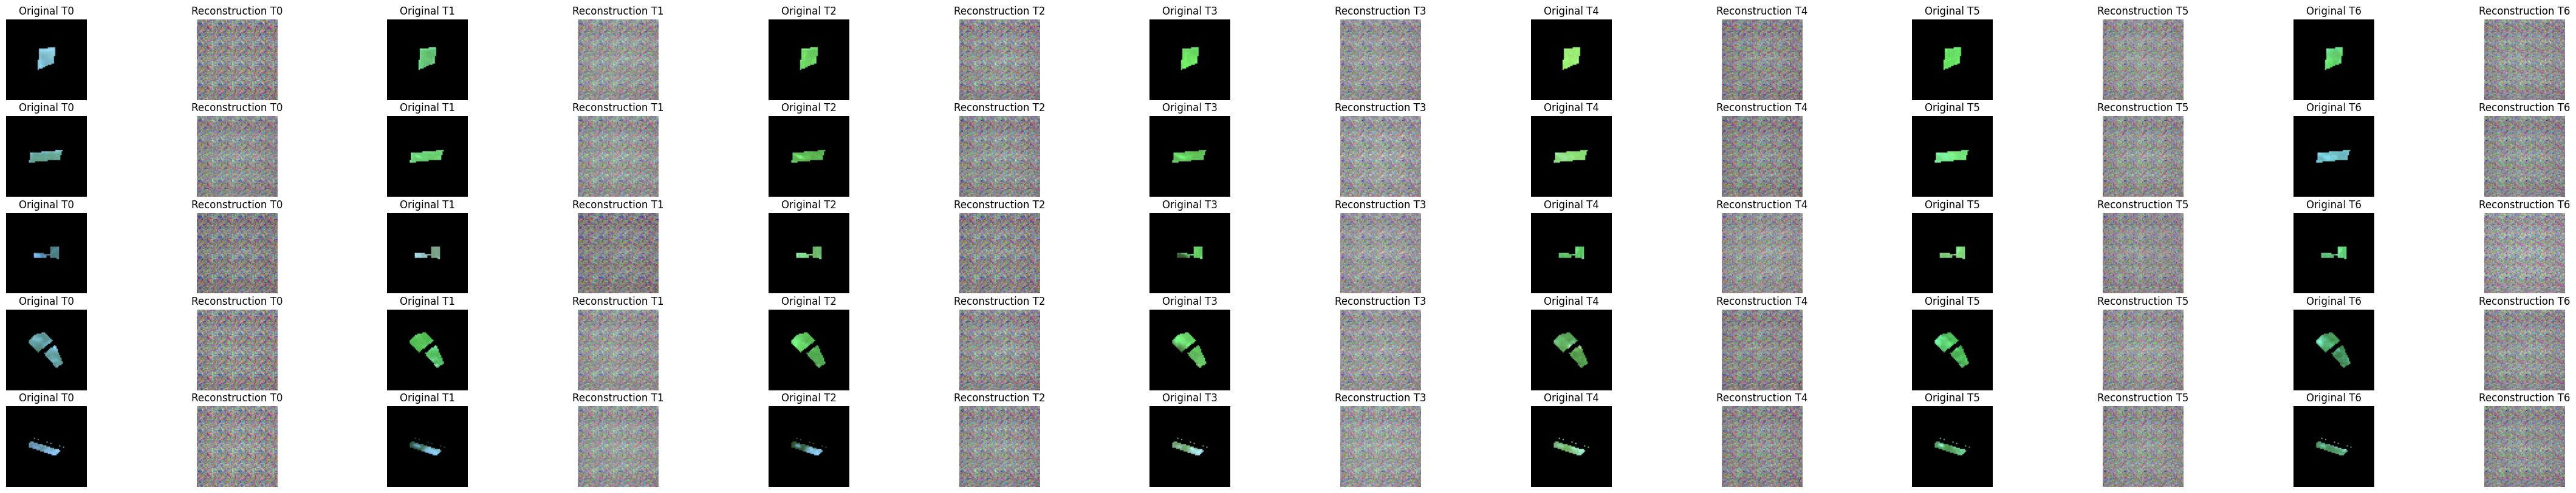

In [32]:
visualize_temporal_reconstructions_mae(trained_model, dataloader_eval, device, num_images=5, T=7)

Use trained Encoder part to get the features for train, test and evaluation Data

In [ ]:
# train_features, train_fno = extract_latent_features_mae(trained_model, dataloader_train, device)
# test_features, test_fno = extract_latent_features_mae(trained_model, dataloader_test, device)
# eval_features, eval_fno = extract_latent_features_mae(trained_model, dataloader_eval, device)

# train_features = train_features.cpu()
# test_features = test_features.cpu()
# eval_features = eval_features.cpu()

# combined_train_features = torch.cat((train_features, test_features), dim=0)
# combined_train_coords = train_fno + test_fno

K-means on extracted features

In [ ]:
# kmeans = train_kmeans_patches(combined_train_features, n_clusters=2, random_state=103)

# train_patch_predictions = kmeans.predict(combined_train_features.reshape(combined_train_features.size(0), -1).numpy().astype(np.float32))
# eval_patch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

In [ ]:
# acc, precision, recall, f1, f2 = get_clustering_accuracy(field_numbers_eval, eval_patch_predictions, config.labels_path)
# print("Accuracy:",acc)
# print("Precision:",precision)
# print("Recall:",recall)
# print("F1-score:",f1)
# print("F2-score:",f2)